In [171]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dsets

import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.manual_seed(232)
use_gpu = False

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

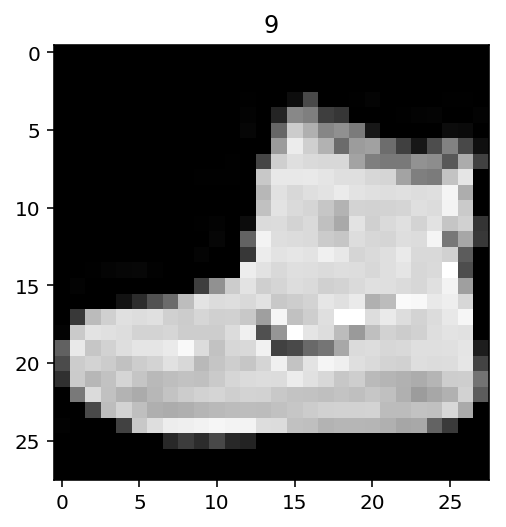

In [4]:
plt.imshow(train_loader.dataset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, z_size, output_size, dropout_p=0.1):
        super(Net, self).__init__()
        self.dropout_p = dropout_p
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc2(x)
        #x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc3(x)
        x = F.dropout(x, p=self.dropout_p, training=True)
        y = self.fc4(x)
        
        return y    

In [177]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, z_size, output_size, dropout_p=0.1):
        super(Net, self).__init__()
        self.dropout_p = dropout_p
        self.fc1 = nn.Linear(input_size, z_size) 
        self.fc2 = nn.Linear(z_size, output_size)
        
    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x   

In [178]:
# Hyper Parameters 
input_size = 784
hidden_size = 200
z_size = 50
output_size = 784
num_epochs = 100
batch_size = 100
learning_rate = 0.01
dropout = 0.1

In [179]:
model = Net(input_size=input_size,
            hidden_size=hidden_size,
            z_size=z_size,
            output_size=output_size,
            dropout_p=dropout)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay = 0.0,momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=[70,90], 
                                                 gamma=0.1)
loss_criterion = torch.nn.MSELoss()

In [180]:
mean_trainloss, std_trainloss = [], []
mean_testloss, std_testloss = [], []
# Train the Model
for epoch in range(num_epochs):
    #Train step
    model.train()
    epoch_trainloss = []
    for train_images, train_labels in train_loader:  
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        # Convert torch tensor to Variable
        train_images = train_images.view(-1, 28*28)
        train_labels = train_images
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        train_outputs = model(train_images)
        train_loss = loss_criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        epoch_trainloss.append(train_loss.detach().numpy())
    mean_trainloss.append(np.mean(epoch_trainloss))
    std_trainloss.append(np.std(epoch_trainloss))
    scheduler.step()
        
    #Test step
    model.eval()
    epoch_testloss = []
    for test_images, test_labels in test_loader:
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        test_images = test_images.view(-1, 28*28)
        test_labels = test_images
        
        #Forward
        test_outputs = model(test_images)
        test_loss = loss_criterion(test_outputs, test_labels)
        epoch_testloss.append(test_loss.detach().numpy())
    mean_testloss.append(np.mean(epoch_testloss))
    std_testloss.append(np.std(epoch_testloss))
    
    print (f'''Epoch {epoch+1}/{num_epochs}, 
    trainloss: {np.mean(epoch_trainloss)}, 
    testloss : {np.mean(epoch_testloss)}''')

Epoch 1/100, 
    trainloss: 0.7274774312973022, 
    testloss : 0.49343979358673096
Epoch 2/100, 
    trainloss: 0.4457617700099945, 
    testloss : 0.4070061147212982
Epoch 3/100, 
    trainloss: 0.3811880350112915, 
    testloss : 0.35449331998825073
Epoch 4/100, 
    trainloss: 0.3367595970630646, 
    testloss : 0.3198733329772949
Epoch 5/100, 
    trainloss: 0.30935904383659363, 
    testloss : 0.29845377802848816
Epoch 6/100, 
    trainloss: 0.2911399304866791, 
    testloss : 0.283063679933548
Epoch 7/100, 
    trainloss: 0.27773573994636536, 
    testloss : 0.27172237634658813
Epoch 8/100, 
    trainloss: 0.2676582336425781, 
    testloss : 0.2631188631057739
Epoch 9/100, 
    trainloss: 0.25980499386787415, 
    testloss : 0.25621676445007324
Epoch 10/100, 
    trainloss: 0.2533382773399353, 
    testloss : 0.2503514587879181
Epoch 11/100, 
    trainloss: 0.24787403643131256, 
    testloss : 0.24531450867652893
Epoch 12/100, 
    trainloss: 0.24309730529785156, 
    testloss 

Epoch 96/100, 
    trainloss: 0.16929112374782562, 
    testloss : 0.1694055050611496
Epoch 97/100, 
    trainloss: 0.1692592054605484, 
    testloss : 0.16946099698543549
Epoch 98/100, 
    trainloss: 0.1692664623260498, 
    testloss : 0.1694115698337555
Epoch 99/100, 
    trainloss: 0.16927075386047363, 
    testloss : 0.16941173374652863
Epoch 100/100, 
    trainloss: 0.16925416886806488, 
    testloss : 0.16934923827648163


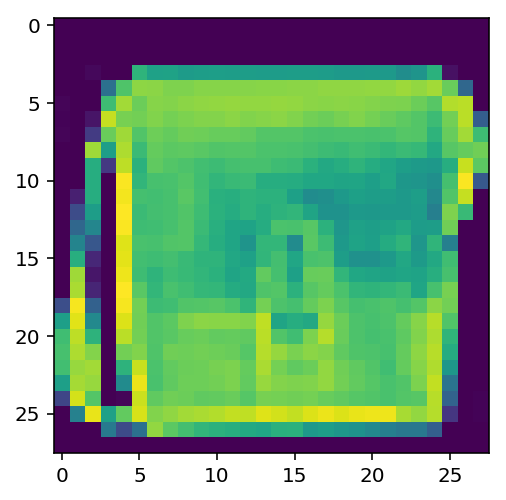

In [187]:
i = 3

test_outputs = model(test_images)


t = test_images[i].detach().numpy()
lol=test_outputs[i].detach().numpy()

plt.imshow(np.reshape(t,newshape=[28,28]))

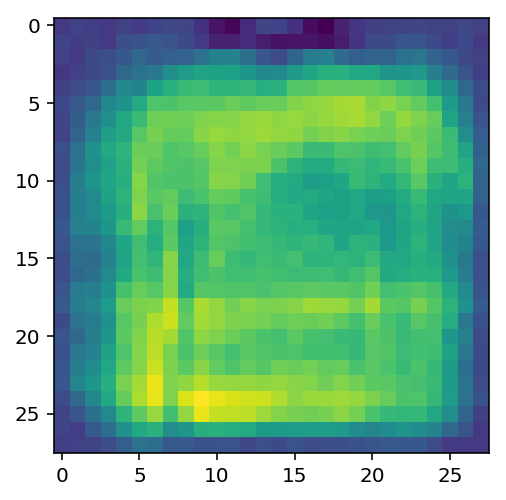

In [188]:
plt.imshow(np.reshape(lol,newshape=[28,28]))

In [189]:
N = 1000
results = np.zeros([N,784])
for j in range(N):
    output = model(test_images)
    results[j,:]=output[i].detach().numpy()

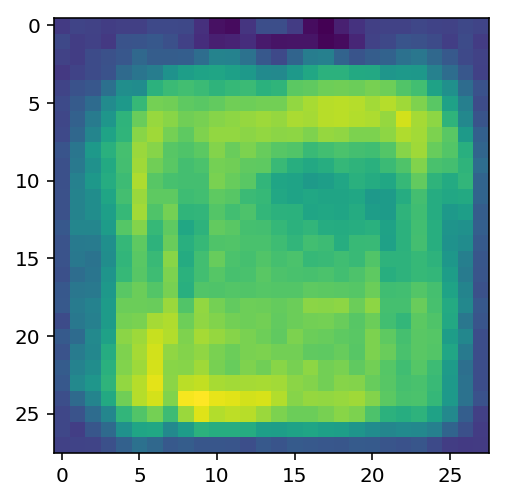

In [190]:
final_mean = np.mean(results,axis=0)
final_std = np.std(results,axis=0)
plt.imshow(np.reshape(final_mean,newshape=[28,28]))

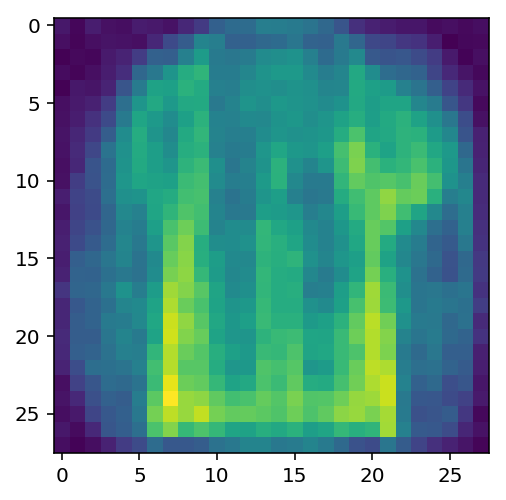

In [186]:
plt.imshow(np.reshape(final_std,newshape=[28,28]))

In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from z24_dataset import z24Dataset

ModuleNotFoundError: No module named 'z24_dataset'